# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 07.06.2024**

**Мягкий дедлайн: 23.06.2024 23:59 MSK**

**Жёсткий дедлайн: 23.06.2024 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


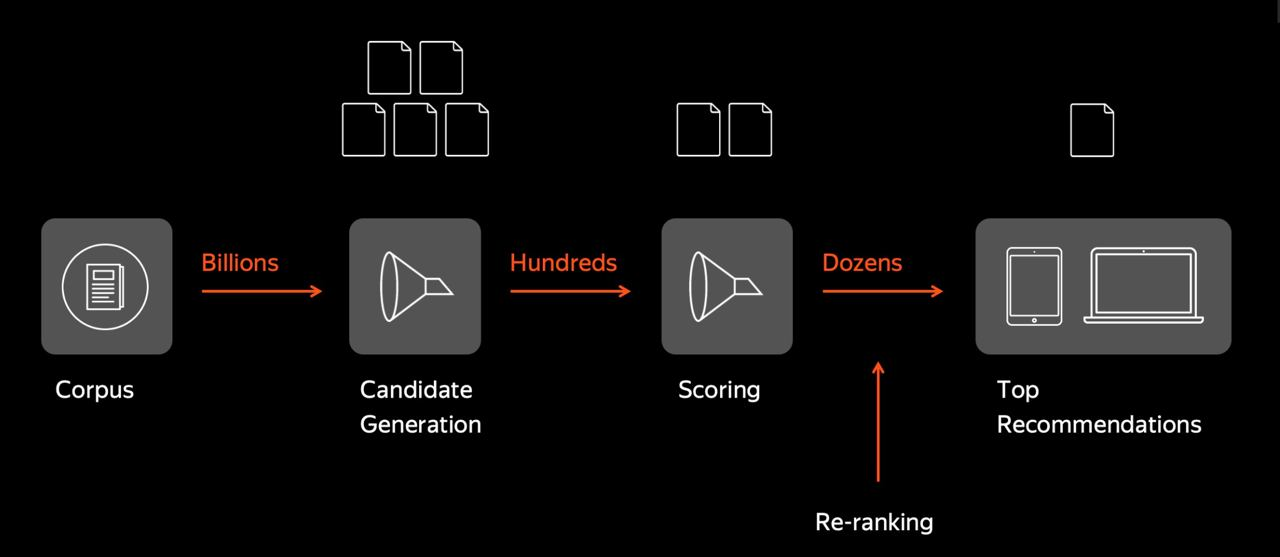

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    map = 0
    for relevant_u, predicted_u in zip(relevant, predicted):
        relevant_u = set(relevant_u)
        relevance = np.array([int(item in relevant_u) for item in predicted_u[:k]])
        prec_u = np.cumsum(relevance) / np.arange(1, k + 1)
        ap_u = np.sum(prec_u * relevance) / min(k, len(relevant_u))
        map += ap_u
    return map / len(relevant)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [5]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [6]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [7]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [8]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [9]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [10]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [12]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int, test_users: List[int]):
        test_preds = []
        
        for uid in range(self.n_users):
            test_preds.append(self.recommend(uid))
        
        test_preds = self.remove_train_items(np.array(test_preds), k)

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [13]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    ratings = ratings.astype(bool)
    user_vector = user_vector.astype(bool)
    items_intersection = np.sum(ratings & user_vector, axis=1)
    items_union = np.sum(ratings | user_vector, axis=1)
    return items_intersection / items_union

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [14]:
class User2User(BaseModel):
    def __init__(self, ratings, alpha=0.02):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = alpha
        self.eps = 1e-5

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        users_similarity = self.similarity(user_vector)

        neighbours_mask = (users_similarity > self.alpha)
        neighbours_mask[uid] = False
        neighbours_ratings = self.R[neighbours_mask]
        neighbours_similarity = users_similarity[neighbours_mask]

        relevance = neighbours_similarity @ neighbours_ratings / (np.sum(np.abs(neighbours_similarity)) + self.eps)
        return np.argsort(relevance).tolist()[::-1]

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [15]:
class TopPopular(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.popular_items = np.argsort(np.sum(self.R, axis=0)).tolist()[::-1]

    def recommend(self, uid: int):
        return self.popular_items
    

class Random(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

    def recommend(self, uid: int):
        all_items = np.arange(self.n_items)
        np.random.shuffle(all_items)
        return all_items.tolist()

In [16]:
user2user_model = User2User(train_ratings)
user2user_recs = user2user_model.get_test_recommendations(50, test_users)

toppop_model = TopPopular(train_ratings)
toppop_recs = toppop_model.get_test_recommendations(50, test_users)

random_model = Random(train_ratings)
random_recs = random_model.get_test_recommendations(50, test_users)

model_predictions = {
    'User2User': user2user_recs,
    'TopPopular': toppop_recs,
    'Random': random_recs
}

In [19]:
mapk_values = {
    'User2User': [],
    'TopPopular': [],
    'Random': []
}

for k in range(1, 50):
    for model in mapk_values.keys():
        mapk_values[model].append(mapk(test_relevant, model_predictions[model], k))

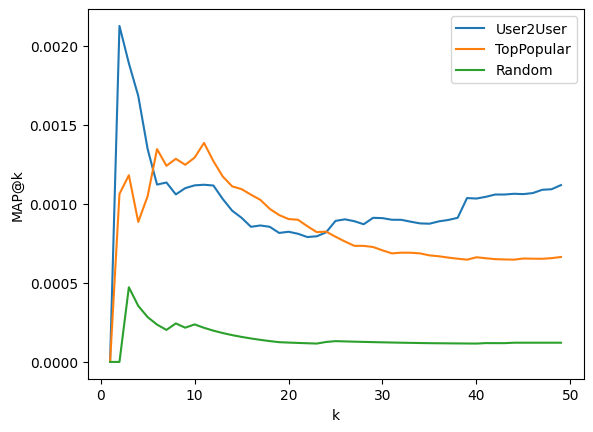

In [20]:
ks = list(range(1, 50))

for model, values in mapk_values.items():
    plt.plot(ks, values, label=model)

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

**Random** - очень плохо, так надо только на вечном контроле, чтобы собирать естественное поведение пользователей

**TopPopular** - очень неплох для k <= 12, а дальше качество ухудшается, потому что попадают скорее всего только топ-10 самых просматриваемых фильмов, остальное уже более локальное

**User2User** - гига-хорош на старте, потому что, вероятно, собирает самые сливки по схожим пользователям, в т.ч. таким образом учитывая общую популярность айтемов. На среднем количестве айтемов [5; 25] - рекомендации похуже популярных, но вот  дальше качество начинает уверенно расти, то есть мы лучше попадаем в широкий список интересов, что важно, например, в рекомендациях онлайн-магазина/ленты постов/музыки

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

После курса рексов я был уверен, что это делается просто заменой на csr_matrix, но не тут то было: sparse форматы как будто не поддерживают срезы по маскам и поэлементные операции умножения, на которых я все выше написал, поэтому мне пришлось засучить рукава и дебагать

In [17]:
from scipy.sparse import csr_matrix, csr_array

def jaccard_csr(ratings, user_vector):
    items_intersection = (ratings @ user_vector.T).sum(axis=1)
    items_union = ratings.sum(axis=1) - items_intersection + user_vector.sum()
    return np.asarray(items_intersection / items_union)


class SparseBaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = csr_matrix(
            (np.ones(self.ratings.shape[0]), (self.ratings['userId'], self.ratings['trackId'])),
            shape=(self.n_users, self.n_items),
        )
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int, test_users: List[int]):
        test_preds = []
        
        for uid in range(self.n_users):
            test_preds.append(self.recommend(uid))
        
        test_preds = self.remove_train_items(np.array(test_preds), k)

        return test_preds[test_users]
    

class SparseUser2User(SparseBaseModel):
    def __init__(self, ratings, alpha=0.02):
        super().__init__(ratings)

        self.similarity_func = jaccard_csr
        self.alpha = alpha
        self.eps = 1e-5

    def similarity(self, user_vector):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = csr_array(self.R[uid])
        users_similarity = self.similarity(user_vector)

        neighbours_mask = (users_similarity > self.alpha)
        neighbours_mask[uid] = False
        
        neighbours_similarity = neighbours_mask * users_similarity

        relevance = csr_array(neighbours_similarity.T) @ self.R / (np.sum(np.abs(neighbours_similarity)) + self.eps)
        return np.argsort(relevance.toarray().squeeze()).tolist()[::-1]
    

class SparseTopPopular(SparseBaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.popular_items = np.argsort(np.asarray(np.sum(self.R, axis=0)).squeeze()).tolist()[::-1]

    def recommend(self, uid: int):
        return self.popular_items

In [22]:
sparse_user2user_model = SparseUser2User(train_ratings)
sparse_user2user_recs = sparse_user2user_model.get_test_recommendations(50, test_users)
(user2user_recs == sparse_user2user_recs).all()

True

In [23]:
%timeit sparse_user2user_model.get_test_recommendations(50, test_users)

2.31 s ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit user2user_model.get_test_recommendations(50, test_users)

12 s ± 689 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
sparse_toppop_model = SparseTopPopular(train_ratings)
sparse_toppop_recs = sparse_toppop_model.get_test_recommendations(50, test_users)
(toppop_recs == sparse_toppop_recs).all()

True

In [26]:
%timeit sparse_toppop_model.get_test_recommendations(50, test_users)

1.12 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit toppop_model.get_test_recommendations(50, test_users)

923 ms ± 76.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


User2User ожидаемо сильно ускорился, а TopPop - нет (и не должен был), потому что в нем нет матвеков

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [28]:
model = SparseUser2User(train_ratings)

In [29]:
user_id = np.random.randint(0, model.n_users)

In [30]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
164,My Favourite Game,['The Cardigans']
177,Paper Planes,['M.I.A.']
234,Wind Of Change,['Scorpions']
344,Somebody Told Me,['The Killers']
464,Tainted Love,['Marilyn Manson']
472,This Is the New Shit,['Marilyn Manson']
683,Animal Instinct,['The Cranberries']
707,Sweet Dreams (Are Made of This),['Marilyn Manson']
710,The Nobodies,['Marilyn Manson']
757,Take A Look Around,['Limp Bizkit']


In [31]:
preds = model.get_test_recommendations(15, test_users)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
8263,Shape Of My Heart,['Sting']
1056,Don't Speak,['No Doubt']
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
10792,Rolling In The Deep,['Adele']
11950,Somebody That I Used To Know,"['Gotye', 'Kimbra']"
6376,"You're Gonna Go Far, Kid",['The Offspring']
18459,Take Me To Church,['Hozier']
10282,Владивосток 2000,['Мумий Тролль']
34046,Feel It Still,['Portugal. The Man']
29105,Human,"[""Rag'n'Bone Man""]"


In [32]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
53887,Clandestina,"['FILV', 'Edmofo']"
53891,Arriba,"['Little Big', 'Tatarka', 'Clean Bandit']"
54003,Sweet Dreams (Are Made Of This),['Marilyn Manson']
54030,Глаза,"['Stella', 'Дельфин']"
54707,I Disagree,['Poppy']
54817,You?,['Two Feet']
54897,Music Sounds Better With You,['Neil Frances']
55034,Dance Monkey,['Tones And I']
55159,Disfruto,['Carla Morrison']
55706,Go Bananas,['Little Big']


Сомнительнооооо, но окэй

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Сначала случайно выбираем объект $(u, i)$ из нашей выборки - это по сути батч для шага. Затем делаем шаг градиентного спуска по нему:

$$\nabla_{p_u}L(u, i) = 2(\langle p_u, q_i \rangle - r_{ui})q_i + 2\lambda p_u$$

$$\nabla_{q_i}L(u, i) = 2(\langle p_u, q_i \rangle - r_{ui})p_u + 2\lambda q_i$$

Тогда шаг выглядит так:

$$p_u^{k + 1} = p_u^k - \eta \nabla_{p_u}L(u^k, i^k)$$

$$q_i^{k + 1} = q_i^k - \eta \nabla_{q_i}L(u^k, i^k)$$

**ALS:**

Сначала фиксируем матрицу Q и делаем обновление по всем пользователям следующего вида:

$$p_u^* = argmin_{p_u}(L(p_u, Q))$$

$$\nabla_{p_u}L = \sum\limits_{i: (u, i) \in R} 2(\langle p_u, q_i \rangle - r_{ui})q_i + 2\lambda p_u = 0$$

$$-\sum\limits_{i: (u, i) \in R} r_{ui}q_i + \sum\limits_{i: (u, i) \in R} p_u^Tq_iq_i + \lambda p_u = 0$$

Заметим, что $p_u^Tq_iq_i = (p_u^Tq_i)q_i = q_i(p_u^Tq_i) = q_i(q_i^Tp_u) = q_iq_i^Tp_u$ $\Rightarrow$

$$-\sum\limits_{i: (u, i) \in R} r_{ui}q_i + (\sum\limits_{i: (u, i) \in R} q_iq_i^T + \lambda I_d)p_u = 0$$

$$p_u^* = (\sum\limits_{i: (u, i) \in R} q_iq_i^T + \lambda I_d)^{-1} (\sum\limits_{i: (u, i) \in R} r_{ui}q_i)$$

Так мы можем обновить вектор каждого пользователя.

На следующем шаге мы наоборот фиксируем P и делаем обновление по всем айтемам в аналогичной манере, получая следующее выражение:

$$q_i^* = (\sum\limits_{u: (u, i) \in R} p_up_u^T + \lambda I_d)^{-1} (\sum\limits_{u: (u, i) \in R} r_{ui}p_u)$$

* Предложенное решение, конечно, неявно опирается на то, что функция по $p_u$ или $q_i$ выпуклая и оптимум находится в нуле градиента. Но оптимизацию можно провести и явно расписывая выражение под argmin без градиентов - делать мы этого конечно же не будем.


**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [18]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        
        self.interactions = np.argwhere(self.R > 0)
        self.dim = dim
        
        assert mode in ['sgd', 'als', 'ials']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 1e-4
        self.lamb = 0.01

    def sgd_grad(self, x, y, r):
        # Считает градиент по первому вектору в точке (x, y)
        return 2 * (np.dot(x, y) - r) * y + 2 * self.lamb * x
    
    def als_step(self, A, ratings):
        # A - векторы представлений пользователей/айтемов
        A_hat = np.einsum('idk,djk->ij', A.T[:, np.newaxis, :], A.T[np.newaxis, :, :]) + self.lamb * np.eye(self.dim)
        A_inv = np.linalg.inv(A_hat)
        a_rate = ratings @ A
        return a_rate @ A_inv.T

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                uid, iid = self.interactions[np.random.randint(len(self.interactions))]
                p_u, q_i, r_ui = self.P[uid], self.Q[iid], self.R[uid][iid]

                p_u_updated = p_u - self.lr * self.sgd_grad(p_u, q_i, r_ui)
                q_i_updated = q_i - self.lr * self.sgd_grad(q_i, p_u, r_ui)

                self.P[uid], self.Q[iid] = p_u_updated, q_i_updated

            elif self.mode == 'als':
                for u in range(self.n_users):
                    Ru = self.R[u]
                    Qu = self.Q[Ru > 0]
                    Rui = Ru[Ru > 0]
                    self.P[u] = self.als_step(Qu, Rui)

                for i in range(self.n_items):
                    Ri = self.R.T[i]
                    Pi = self.P[Ri > 0]
                    Riu = Ri[Ri > 0]
                    self.Q[i] = self.als_step(Pi, Riu)

            elif self.mode == 'ials':
                self.P = (np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.dim)) @ self.Q.T @ self.R.T).T

                self.Q = (np.linalg.inv(self.P.T @ self.P + self.lamb * np.eye(self.dim)) @ self.P.T @ self.R).T

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

Тут пример, как работает np.einsum в ALS

In [35]:
A = np.array([[1, 2, 3],
              [3, 4, 5]])

A[0][:, np.newaxis] @ A[0][np.newaxis, :] + A[1][:, np.newaxis] @ A[1][np.newaxis, :]

array([[10, 14, 18],
       [14, 20, 26],
       [18, 26, 34]])

In [36]:
A.T[:, np.newaxis, :] , A.T[np.newaxis, :, :]

(array([[[1, 3]],
 
        [[2, 4]],
 
        [[3, 5]]]),
 array([[[1, 3],
         [2, 4],
         [3, 5]]]))

In [37]:
np.einsum('idk,djk->ij', A.T[:, np.newaxis, :], A.T[np.newaxis, :, :])

array([[10, 14, 18],
       [14, 20, 26],
       [18, 26, 34]])

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

Переберем классические для DL размеры эмбеддингов

Рассмотрим для начала SGD

In [74]:
dims = [64, 128, 256, 300, 400, 512]

predictions_sgd = dict()
for dim in dims:
    lfm_sgd = LatentFactorModel(train_ratings, dim=dim, mode='sgd')
    lfm_sgd.fit(250000)
    predictions_sgd[dim] = lfm_sgd.get_test_recommendations(50, test_users)

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

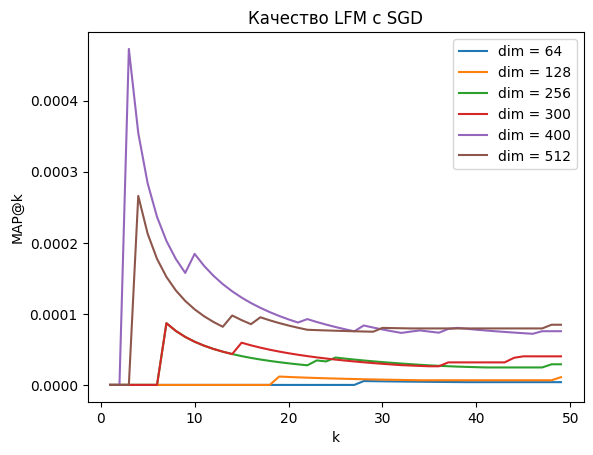

In [75]:
metrics_sgd = {}
for dim, predictions in predictions_sgd.items():
    metrics_sgd[dim] = []
    for k in range(1, 50):
        metrics_sgd[dim].append(mapk(test_relevant, predictions, k))

ks = list(range(1, 50))

for dim, values in metrics_sgd.items():
    plt.plot(ks, values, label=f'dim = {dim}')

plt.title('Качество LFM с SGD')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Сколько бы часов я ни искал баг/тюнил гиперпараметры - sgd получается около рандомным. Это печально, но на сей раз у меня даже нет объяснений. Если делать 0 эпох, то результат получается примерно такой же. Возможно, это просто хаотичные блуждания, так как мы пытаемся все делать по 1 примеру.

In [76]:
epochs = [100000, 200000, 250000, 500000]

predictions_sgd = dict()
for epoch in epochs:
    lfm_sgd = LatentFactorModel(train_ratings, dim=256, mode='sgd')
    lfm_sgd.fit(epoch)
    predictions_sgd[epoch] = lfm_sgd.get_test_recommendations(50, test_users)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

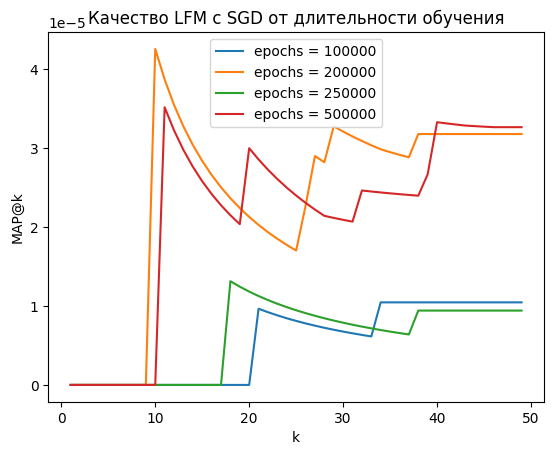

In [77]:
metrics_sgd = {}
for epochs, predictions in predictions_sgd.items():
    metrics_sgd[epochs] = []
    for k in range(1, 50):
        metrics_sgd[epochs].append(mapk(test_relevant, predictions, k))

ks = list(range(1, 50))

for epochs, values in metrics_sgd.items():
    plt.plot(ks, values, label=f'epochs = {epochs}')

plt.title('Качество LFM с SGD от длительности обучения')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Ну тут тоже результат околорандомный - рыжей линии повезло с инитом.

In [78]:
model_predictions['SGD'] = predictions_sgd[200000]
mapk_values['SGD'] = metrics_sgd[200000]

Перейдем к ALS

In [47]:
dims = [32, 64, 128]

predictions_als = dict()
for dim in dims:
    lfm_als = LatentFactorModel(train_ratings, dim=dim, mode='als')
    lfm_als.fit(20)
    predictions_als[dim] = lfm_als.get_test_recommendations(50, test_users)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

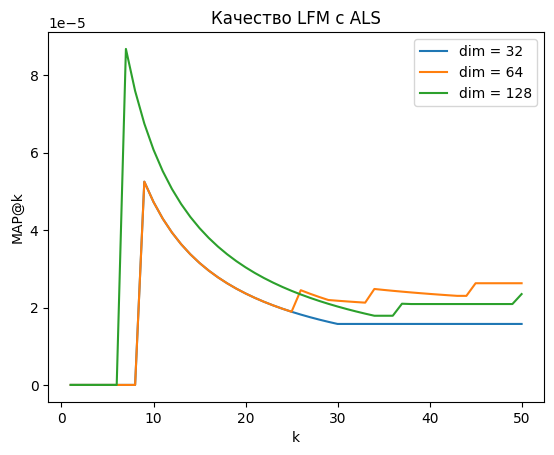

In [48]:
metrics_als = {}
for dim, predictions in predictions_als.items():
    metrics_als[dim] = []
    for k in range(1, 51):
        metrics_als[dim].append(mapk(test_relevant, predictions, k))

ks = list(range(1, 51))

for dim, values in metrics_als.items():
    plt.plot(ks, values, label=f'dim = {dim}')

plt.title('Качество LFM с ALS')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Несколько часов дебага не приблизили меня к разгадке - это очень плохо(

Поэтому было принято от самой базовой реализации ALS перейти к промежуточному шагу между ALS и iALS - заменить все взаимодействия на явные, но не вводить матрицу уверенности. Тогда можно делать переход в чисто матричном виде, оптимизируя $||R - PQ^T||^2$

In [81]:
dims = [64, 128, 256, 512, 1024]

predictions_als = dict()
for dim in dims:
    lfm_als = LatentFactorModel(train_ratings, dim=dim, mode='ials')
    lfm_als.fit(20)
    predictions_als[dim] = lfm_als.get_test_recommendations(50, test_users)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

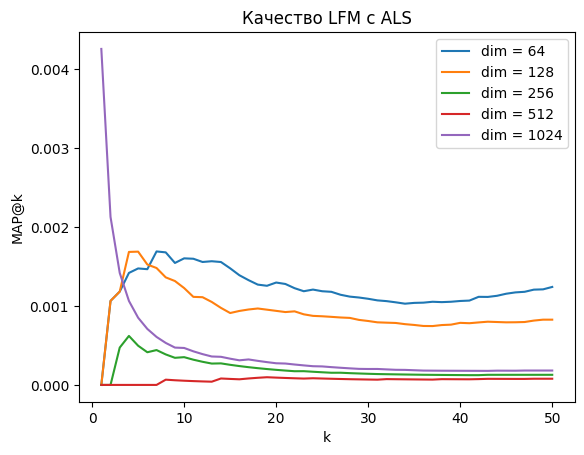

In [82]:
metrics_als = {}
for dim, predictions in predictions_als.items():
    metrics_als[dim] = []
    for k in range(1, 51):
        metrics_als[dim].append(mapk(test_relevant, predictions, k))

ks = list(range(1, 51))

for dim, values in metrics_als.items():
    plt.plot(ks, values, label=f'dim = {dim}')

plt.title('Качество LFM с ALS')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

О боги, так гораздо лучше, хоть и не соответствует исходному заданию на явных интеракциях. Причина, видимо, в тех самых явных интеракциях - их слишком много на весь наш датасет

In [61]:
ratings['userId'].nunique(), ratings['trackId'].nunique(), len(ratings)

(241, 72383, 141454)

В среднем по 2 на трек - негусто, но я ожидал худшего

In [83]:
epochs = [5, 10, 20, 30, 50, 100]

predictions_als = dict()
for epoch in epochs:
    lfm_als = LatentFactorModel(train_ratings, dim=64, mode='ials')
    lfm_als.fit(epoch)
    predictions_als[epoch] = lfm_als.get_test_recommendations(50, test_users)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

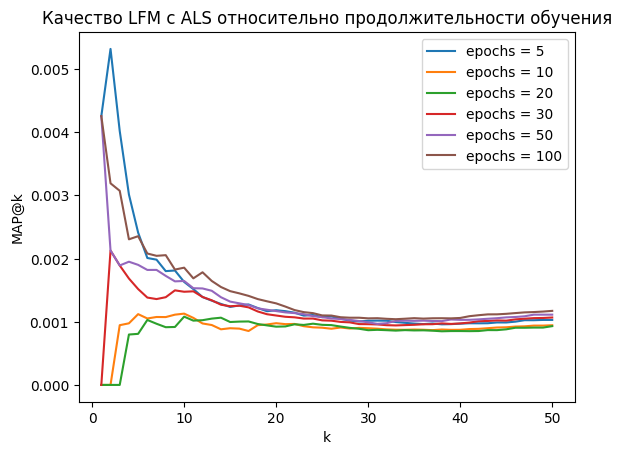

In [84]:
metrics_als = {}
for epochs, predictions in predictions_als.items():
    metrics_als[epochs] = []
    for k in range(1, 51):
        metrics_als[epochs].append(mapk(test_relevant, predictions, k))

ks = list(range(1, 51))

for epochs, values in metrics_als.items():
    plt.plot(ks, values, label=f'epochs = {epochs}')

plt.title('Качество LFM с ALS относительно продолжительности обучения')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Красиво, но особо сильной разницы - нет. Линии на 5 эпох, скорее всего, немного повезло с инициализацией, но выберем мы 100 эпох

In [85]:
model_predictions['als'] = predictions_als[100]
mapk_values['als'] = metrics_als[100]

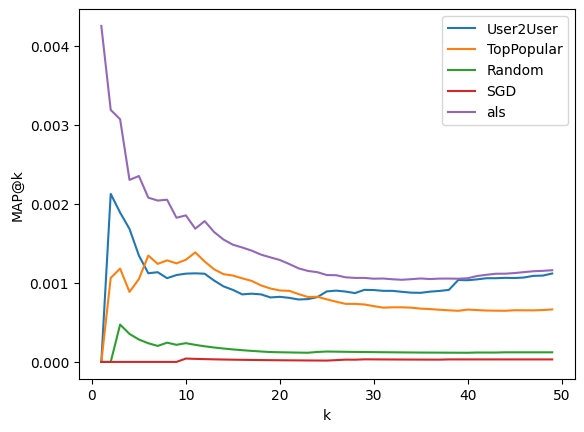

In [86]:
ks = list(range(1, 50))

for model, values in mapk_values.items():
    plt.plot(ks, values[:49], label=model)

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Собственно видно, что ALS сильно лучше всех рассмотренных ранее методов

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [87]:
model_als = LatentFactorModel(ratings, dim=64, mode='ials')
model_als.fit(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [88]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model_als.Q @ model_als.Q[example_trackId]
preds = preds / np.sqrt((model_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [89]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.775146
14898,Critical Distance,['Maybeshewill'],0.693729
16667,Livin' It,['Stick Figure'],0.685266
9689,Bicycle Race,['Queen'],0.683009
5153,Stormbringer,['Deep Purple'],0.683009
17363,"New York, New York","['Frank Sinatra', 'Tony Bennett']",0.681458
2179,Восьмиклассница,['КИНО'],0.672568
13288,Waiting For The Rapture,['Oasis'],0.670623
13289,(Get Off Your) High Horse Lady,['Oasis'],0.670623


Вообще говоря, очень правдободобно

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

Тут вроде не просили выводить формулы, но если что полны вывод неплохо описан [тут](https://education.yandex.ru/handbook/ml/article/rekomendacii-na-osnove-matrichnyh-razlozhenij) 

In [62]:
class iALS(BaseModel):
    def __init__(self, ratings, dim=128, alpha=40):
        super().__init__(ratings)
        self.iR = (self.R > 0).astype(int)

        self.alpha = alpha
        self.C = 1 + alpha * self.R

        self.dim = dim

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lamb = 0.01

    def als_step(self, A, C, p):
        # A - векторы представлений пользователей/айтемов
        AC = A.T @ C
        A_left = AC @ A + self.lamb * np.eye(self.dim)
        A_right = (p @ AC.T).T
        return np.linalg.inv(A_left) @ A_right

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            for u in range(self.n_users):
                pu = self.iR[u]
                Cu = np.diag(self.C[u])
                self.P[u] = self.als_step(self.Q, Cu, pu)

            for i in range(self.n_items):
                pi = self.iR.T[i]
                Ci = np.diag(self.C.T[i])
                self.Q[i] = self.als_step(self.P, Ci, pi)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

In [63]:
dims = [64]

predictions_ials = dict()
for dim in dims:
    lfm_ials = iALS(ratings, dim=dim)
    lfm_ials.fit(5)
    predictions_als[dim] = lfm_ials.get_test_recommendations(50, test_users)

  0%|          | 0/5 [00:00<?, ?it/s]

(64, 64)
(72383, 64) (72383, 72383) (64, 72383) (72383,)
(64,)


KeyboardInterrupt: 

К сожалению, ноут не тянет((

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [20]:
model_1 = SparseUser2User(train_ratings)
test_pred_user2user = model_1.get_test_recommendations(100, test_users)

model_2 = LatentFactorModel(train_ratings, dim=64, mode='ials')
model_2.fit(100)
test_pred_als = model_2.get_test_recommendations(100, test_users)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
test_preds = [np.hstack([test_pred_user2user[i], test_pred_als[i]]) for i in range(len(test_pred_als))]

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [22]:
df = pd.DataFrame()

for uid, relevant, predicted_items in zip(test_users, test_relevant, test_preds):
    jac_mean = jaccard(model_2.R, model_2.R[uid]).mean()
    total_listened = model_2.R[uid].sum()

    last_relevant = set(relevant[-50:])

    for iid in predicted_items:
        user_item_cos = np.dot(model_2.P[uid], model_2.Q[iid]) / (np.linalg.norm(model_2.P[uid]) * np.linalg.norm(model_2.Q[iid]))
        users_listened = model_2.R.T[iid].mean()
        target = int(iid in last_relevant)

        info = {"user_id": uid,
                "track_id": iid,
                "jaccard": jac_mean,
                "listened_tracks": total_listened,
                "cos_dist": user_item_cos,
                "track_listened_part": users_listened,
                "target": target}

        df = pd.concat((df, pd.Series(info).to_frame().T))

In [23]:
df['user_id'] = df['user_id'].astype(int)
df['track_id'] = df['track_id'].astype(int)
df['listened_tracks'] = df['listened_tracks'].astype(int)
df['target'] = df['target'].astype(int)

In [135]:
df.sample(5)

,user_id,track_id,jaccard,listened_tracks,cos_dist,track_listened_part,target
0,116,48893,0.014002,1452,0.009000,0.078838,0
0,46,20620,0.012305,407,0.133716,0.099585,0
0,36,3574,0.015122,294,0.171625,0.136929,0
0,215,2807,0.013148,333,0.343487,0.033195,0
0,118,12556,0.014679,663,0.023575,0.095436,0


In [24]:
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=['target']), df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

In [25]:
# Для Pool надо посортить
train_sorted = X_train["user_id"].argsort()
X_train = X_train.iloc[train_sorted]
y_train = y_train.iloc[train_sorted]

test_sorted = X_test["user_id"].argsort()
X_test = X_test.iloc[test_sorted]
y_test = y_test.iloc[test_sorted]

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [26]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=X_train.user_id)
test_pool = catboost.Pool(X_test, y_test, group_id=X_test.user_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [27]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(verbose=False)
clf.fit(train_pool)

In [39]:
pd.concat([X_test, y_test], axis=1)

,user_id,track_id,jaccard,listened_tracks,cos_dist,track_listened_part,target
0,0,21410,0.007585,206,0.349333,0.033195,0
0,0,24143,0.007585,206,0.102153,0.024896,0
0,0,14853,0.007585,206,0.408442,0.012448,0
0,0,29760,0.007585,206,0.408442,0.012448,0
0,0,1275,0.007585,206,0.413963,0.037344,0
...,...,...,...,...,...,...,...
0,240,22735,0.008189,1668,0.005513,0.016598,0
0,240,48576,0.008189,1668,0.007635,0.074689,0
0,240,54474,0.008189,1668,0.010787,0.033195,0
0,240,22032,0.008189,1668,-0.001935,0.016598,0


In [48]:
test_relevant_2 = []
test_users_2 = []
for user_id, user_data in pd.concat([X_test, y_test], axis=1).groupby('user_id'):
    users_relevance = []
    for track, target in zip(user_data['track_id'], user_data['target']):
        if target == 1:
            users_relevance.append(track)
    if users_relevance != []:
        test_relevant_2.append(users_relevance)
        test_users_2.append(user_id)

In [51]:
len(test_users_2)

71

In [49]:
relevance = clf.predict_proba(test_pool)
predictions = pd.DataFrame({'user_id': X_test['user_id'], 'track_id': X_test['track_id'], 'relevance': relevance[:, 1]}).sort_values(by=["user_id"])

preds = []
for user_id, user_data in predictions.groupby('user_id'):
    user_preds = list(zip(user_data['relevance'], user_data['track_id']))
    user_preds.sort(reverse=True)
    if user_id in test_users_2:
        preds.append([item[1] for item in user_preds[:20]])

mapk(test_relevant_2, preds, 20)

0.6282109567838648

In [50]:
relevance = clf.predict_proba(test_pool)
predictions = pd.DataFrame({'user_id': X_test['user_id'], 'track_id': X_test['track_id'], 'relevance': relevance[:, 1]}).sort_values(by=["user_id"])

preds = []
for user_id, user_data in predictions.groupby('user_id'):
    user_preds = list(zip(user_data['relevance'], user_data['track_id']))
    user_preds.sort(reverse=True)
    preds.append([item[1] for item in user_preds[:20]])

mapk(test_relevant, preds, 20)

0.01909222737930496

Уж слишком хороший скор получился. Но будем честны - мы проверяем на том, на чем учились (test_relevant), поэтому к протоколу тестирования есть вопросики. Если протестировать только на отложенных треках, то метрика еще больше, но там просто очень мало пользователей.

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [58]:
from catboost import CatBoostRanker

# NDCG отчасти - дифференцируемая прокски метрика к map@k
clf = CatBoostRanker(eval_metric="NDCG", verbose=False)
clf.fit(train_pool)

In [59]:
relevance = clf.predict(test_pool)
predictions = pd.DataFrame({'user_id': X_test['user_id'], 'track_id': X_test['track_id'], 'relevance': relevance}).sort_values(by=["user_id"])

preds = []
for user_id, user_data in predictions.groupby('user_id'):
    user_preds = list(zip(user_data['relevance'], user_data['track_id']))
    user_preds.sort(reverse=True)
    preds.append([item[1] for item in user_preds[:20]])

mapk(test_relevant, preds, 20)

0.01906025221804814

Примерно такой же результат - к сожалению или к счастью.